## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
# Load data
df = pd.read_csv('AZN-AstraZeneca.csv')

## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,41.610001,41.759998,41.480000,41.759998,36.845528,4590000
2019-03-04,41.730000,41.810001,41.389999,41.689999,36.783760,3948200
2019-03-05,41.560001,42.610001,41.560001,42.310001,37.330803,5668200
2019-03-06,42.360001,42.389999,41.930000,42.029999,37.083748,2490000
2019-03-07,41.610001,41.770000,41.330002,41.660000,36.757298,5283900
...,...,...,...,...,...,...
2024-02-23,64.959999,65.930000,64.949997,65.830002,65.830002,7388200
2024-02-26,66.080002,66.370003,65.750000,65.930000,65.930000,4597900
2024-02-27,65.940002,66.459999,65.769997,66.330002,66.330002,4433500


## Scale Data

In [4]:
# Select 'Close' column
data = df['Close'].values

In [5]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

## Split the data into train and test

In [6]:
# Define the size of train and test
train_size = int(len(data_scaled) * 0.6)
test_size = len(data_scaled) - train_size

# Split the data into train and test set
train_data = data_scaled[0 : train_size, :]
test_data = data_scaled[train_size : len(data_scaled), :]

## Create and add data into X, y

In [7]:
def add_data(data, sequence_length=1):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [8]:
# Reshape into X=t,t+1,t+2..t+60 and Y=t+60
sequence_length = 60

# Get last data for test
train_last_windowsize = train_data[-sequence_length:]

test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)

# Reshape inputs to [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Build Model

In [9]:
model = Sequential() # Encapsulate the sequence of the inner layers

# 4 LSTM layers
model.add(LSTM(units = 50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# 1 Dense layer
model.add(Dense(units=1)) 

# Optimizer
model.compile(optimizer = 'adam', loss='mean_squared_error')

D:\Anaconda\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training Model

In [10]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
22/22 - 9s - 426ms/step - loss: 0.0394
Epoch 2/50
22/22 - 2s - 73ms/step - loss: 0.0084
Epoch 3/50
22/22 - 2s - 77ms/step - loss: 0.0065
Epoch 4/50
22/22 - 2s - 80ms/step - loss: 0.0052
Epoch 5/50
22/22 - 2s - 75ms/step - loss: 0.0051
Epoch 6/50
22/22 - 2s - 82ms/step - loss: 0.0054
Epoch 7/50
22/22 - 3s - 122ms/step - loss: 0.0053
Epoch 8/50
22/22 - 2s - 81ms/step - loss: 0.0054
Epoch 9/50
22/22 - 2s - 83ms/step - loss: 0.0051
Epoch 10/50
22/22 - 2s - 83ms/step - loss: 0.0048
Epoch 11/50
22/22 - 2s - 80ms/step - loss: 0.0049
Epoch 12/50
22/22 - 2s - 89ms/step - loss: 0.0045
Epoch 13/50
22/22 - 2s - 78ms/step - loss: 0.0045
Epoch 14/50
22/22 - 2s - 87ms/step - loss: 0.0046
Epoch 15/50
22/22 - 2s - 88ms/step - loss: 0.0040
Epoch 16/50
22/22 - 2s - 87ms/step - loss: 0.0041
Epoch 17/50
22/22 - 2s - 81ms/step - loss: 0.0040
Epoch 18/50
22/22 - 2s - 81ms/step - loss: 0.0041
Epoch 19/50
22/22 - 2s - 88ms/step - loss: 0.0042
Epoch 20/50
22/22 - 2s - 86ms/step - loss: 0.0040
Epoch 2

## Predict and Inverse Transform the Predictions

In [11]:
y_pred = model.predict(X_test)

# Inverse transform the predictions
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step


## Calculate the error of the model

In [12]:
# The error in test set
test_mape = mean_absolute_percentage_error(y_pred, y_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test set: ", test_mape)
print(f"RMSE on Test set: ", test_rmse)
print(f"MSLE on Test set: ", test_msle)

MAPE on Test set:  0.027380832147305852
RMSE on Test set:  2.1086566890436753
MSLE on Test set:  0.0009922700342087996


## Predict Close price for 60 next days

In [13]:
# Select the last day of current index
last_date = df.index[-1]

# Add a new day after the last day
next_date = last_date + pd.DateOffset(days=1)

# Generate a list of index only starting from the next day in 60 days
index_next_60_days = pd.date_range(start=next_date, periods=60).tolist()

# Predict Close price for 60 next days
last_sequence_days = data_scaled[-sequence_length:].reshape(1, -1, 1)

y_next_60_days = []

for i in range(60):
    # Predict Close price for next day
    next_day_pred = model.predict(last_sequence_days)
    
    # Save the predict value
    y_next_60_days.append(next_day_pred[0][0])
    
    # Update information of the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━

In [14]:
# Show the result of predict 60 next days 
y_next_60_days = scaler.inverse_transform(np.array(y_next_60_days).reshape(-1, 1))
print(y_next_60_days.flatten())

[65.02902  64.749855 64.39237  64.02984  63.69471  63.393826 63.123272
 62.877396 62.652187 62.445564 62.256416 62.08347  61.92534  61.780216
 61.6461   61.521053 61.403267 61.291164 61.183464 61.079086 60.977146
 60.877014 60.77815  60.680206 60.58287  60.486023 60.389523 60.293377
 60.197556 60.10219  60.007236 59.91268  59.81862  59.72509  59.632183
 59.53994  59.44837  59.357517 59.267414 59.178093 59.0896   59.001915
 58.915146 58.82927  58.744186 58.660088 58.577095 58.495056 58.41394
 58.333717 58.25433  58.175735 58.09791  58.020863 57.944603 57.869144
 57.7943   57.72017  57.646717 57.574024]


## Model visualization

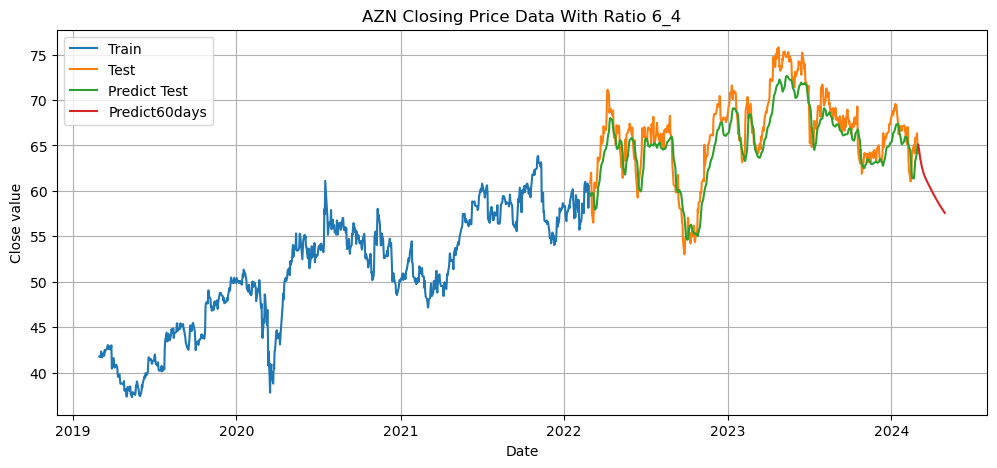

In [15]:
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df[:train_size].index, train_data)

# Test set
plt.plot(df[train_size:].index, test_data)

# Predict in test set
plt.plot(df[train_size:].index, y_pred)

# Predict 60 next days
plt.plot(index_next_60_days, y_next_60_days)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict60days'])
plt.grid()
plt.title("AZN Closing Price Data With Ratio 6_4")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('Image/RNN_64_60days_AZN.png')
plt.show()